In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_n_samples = train_df.shape[0]
print("Number of training samples:", train_n_samples)

Number of training samples: 7613


In [6]:
test_n_samples = test_df.shape[0]
print("Number of test samples:", test_n_samples)

Number of test samples: 3263


In [7]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
train_df_tuned = train_df.drop(columns=['location'])
test_df_tuned = test_df.drop(columns=['location'])

In [10]:
train_df_tuned.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
import re
import string

In [12]:
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Removes links
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

In [13]:
def clean_text2(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

In [14]:
test = train_df_tuned.loc[365, 'text']
print(test)
test2 = clean_text(test)
print(test2)
test3 = clean_text2(test)
print(test3)

One Direction Is my pick for http://t.co/q2eBlOKeVE Fan Army #Directioners http://t.co/eNCmhz6y34 x1386
One Direction Is my pick for Fan Army #Directioners x1386
one direction is my pick for fan army directioners


In [15]:
def get_hashtags(tweet):
    return ''.join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'
def get_mentions(tweet):
    return ''.join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def get_links(tweet):
    return ''.join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def df_processing(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: get_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: get_mentions(x))
    df['links'] = df['text'].apply(lambda x: get_links(x))
    
    
    return df

In [16]:
train_df_tuned_2 = df_processing(train_df_tuned)
train_df_tuned_2.head()

,id,keyword,text,target,text_clean,hashtags,mentions,links
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no
2,5,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaskawildfires,no,no


In [17]:
test_df_tuned_2 = df_processing(test_df_tuned)

In [18]:
import transformers
import torch

c:\users\oshan\data science projects\nlp with disaster tweets\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

bert_model = transformers.BertModel.from_pretrained('bert-base-uncased')

def get_keywords(tweet):
    tokens = tokenizer.encode(tweet, add_special_tokens=True)
    if len(tokens) == 0:
        return []
    input_ids = torch.tensor([tokens])
    with torch.no_grad():
        outputs = bert_model(input_ids)
        embeddings = outputs.last_hidden_state[0]
    sentence_embedding = torch.sum(embeddings, dim=0)
    if len(sentence_embedding) < 3:
        # return fewer than 3 keywords if there aren't enough embeddings
        num_keywords = len(sentence_embedding)
    else:
        num_keywords = 3
    keywords = []
    for i in sentence_embedding.argsort()[-num_keywords:]:
        if i >= len(tokens):
            continue
        keywords.append(tokenizer.decode(tokens[i]))
    return keywords[::-1]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
train_df_tuned_3 = train_df_tuned_2

for i in range(len(train_df_tuned_3)):
    if pd.isnull(train_df_tuned_3.loc[i, 'keyword']):
        keywords = get_keywords(train_df_tuned_3.loc[i, 'text_clean'])
        train_df_tuned_3.loc[i, 'keyword'] = ', '.join(keywords)


train_df_tuned_3.head()

,id,keyword,text,target,text_clean,hashtags,mentions,links
0,1,o f,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no
1,4,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no
2,5,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no
3,6,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaskawildfires,no,no


In [21]:
test_df_tuned_3 = test_df_tuned_2
for i in range(len(test_df_tuned_3)):
    if pd.isnull(test_df_tuned_3.loc[i, 'keyword']):
        keywords = get_keywords(test_df_tuned_3.loc[i, 'text_clean'])
        test_df_tuned_3.loc[i, 'keyword'] = ', '.join(keywords)

In [22]:
train_df_tuned_3.isnull().sum()

id            0
keyword       0
text          0
target        0
text_clean    0
hashtags      0
mentions      0
links         0
dtype: int64

Text(0.5, 1.0, 'Distribution')

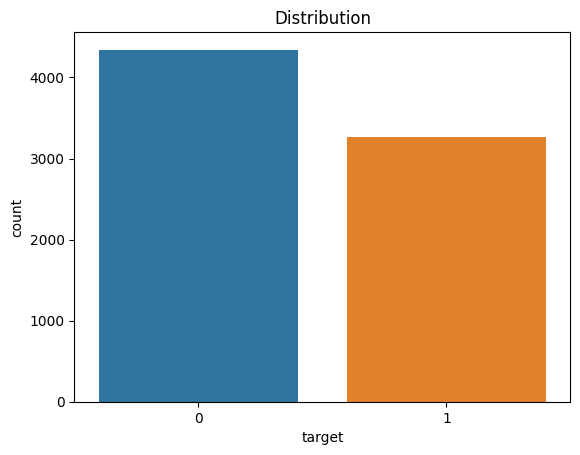

In [23]:
sns.countplot(x='target', data=train_df_tuned_3)
plt.title("Distribution")

In [24]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

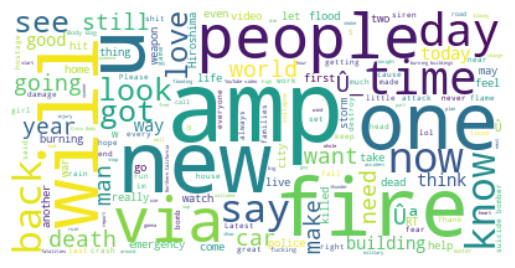

In [25]:
text = ''.join(tweet for tweet in train_df_tuned_3.text_clean)
wordcloud = WordCloud(max_font_size=80, max_words=160, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

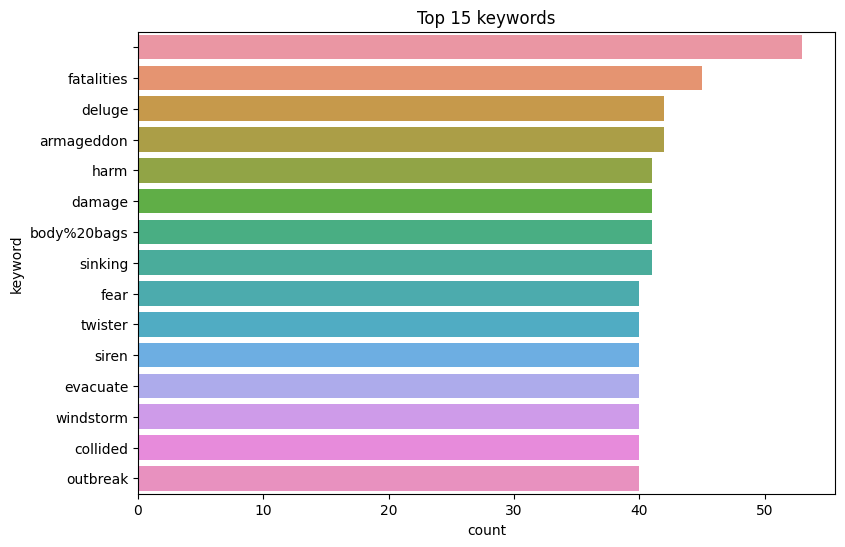

In [26]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_df_tuned_3.keyword, order = train_df_tuned_3.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

In [27]:
def tweet_stats(df):
    df['text_len'] = df['text_clean'].apply(len)
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train_df_stats = tweet_stats(train_df_tuned_3)
test_df_stats = tweet_stats(test_df_tuned_3)

In [28]:
train_df_stats.head()

,id,keyword,text,target,text_clean,hashtags,mentions,links,text_len,word_count,stop_word_count,hashtag_count,punctuation_count,mention_count,link_count,caps_count,caps_ratio
0,1,o f,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no,69,13,6,1,1,1,1,10,0.144928
1,4,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no,38,7,0,1,1,1,1,5,0.131579
2,5,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no,133,22,11,1,3,1,1,2,0.015038
3,6,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no,64,8,1,1,2,1,1,1,0.015625
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaskawildfires,no,no,87,16,7,1,2,1,1,3,0.034483


In [29]:
train_df_stats['keyword'] = train_df_stats['keyword'].str.replace(' ','')

In [30]:
train_df_stats['keyword'].unique()

array(['of', '', 'the', 'tornado', 'ablaze', 'accident', 'aftershock',
       'airplane%20accident', 'ambulance', 'annihilated', 'annihilation',
       'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack',
       'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism',
       'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard',
       'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition'

#### Use the more clean data to train lr model

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

features_to_drop = ['id', 'keyword','text','text_clean', 'hashtags', 'mentions','links']

scaler = MinMaxScaler()

X_train = train_df_stats.drop(columns=features_to_drop + ['target'])
y_train = train_df_stats['target']

X_test = test_df_stats.drop(columns=features_to_drop)

lr = LogisticRegression(solver='liblinear', random_state=777)

pipeline = Pipeline([('scale',scaler), ('lr', lr)])

pipeline.fit(X_train, y_train)

y_test = pipeline.predict(X_test)

sample_submission = pd.read_csv("sample_submission.csv")

submit = sample_submission.copy()
submit.target = y_test
submit.to_csv('submit_lr.csv', index=False)